# Hyperparamter Tuning with SageMaker TensorFlow Container

This tutorial focuses on how to create a convolutional neural network model to train the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using **SageMaker TensorFlow container**. It leverages hyperparameter tuning to kick off multiple training jobs with different hyperparameter combinations, to find the one with best model training result.

## Set Up the Environment 
We will set up a few things before starting the workflow:

1. A boto session object to manage interactions with the Amazon SageMaker APIs. 
2. An execution role which will be passed to SageMaker for accessing your AWS resources

In [2]:
import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()

## Data
We will download the MNIST data from a public S3 bucket and save it in a temporary directory.

In [3]:
import logging
import boto3
from botocore.exceptions import ClientError

public_bucket = 'sagemaker-sample-files'
local_data_dir = '/tmp/data'

# Download training and testing data from a public S3 bucket
def download_from_s3(data_dir='/tmp/data', train=True):
    """Download MNIST dataset and convert it to numpy array
    
    Args:
        data_dir (str): directory to save the data
        train (bool): download training set
    
    Returns:
        None
    """
    # project root
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"
    
    # download objects
    s3 = boto3.client('s3')
    bucket = public_bucket
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3(local_data_dir, True)
download_from_s3(local_data_dir, False)

## Set Up a Tensorflow Training Job
A TensorFlow training job is defined by using the `TensorFlow` estimator class. It lets you run your training script on SageMaker infrastructure in a containerized environment. For more information on how to instantiate it, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#TensorFlow-Estimator).

In [6]:
est = TensorFlow(
    entry_point='train.py',
    source_dir='code', # directory of your training script
    role=role,
    framework_version='2.3.0',
    model_dir='/opt/ml/model',
    py_version='py37',
    instance_type='ml.m5.4xlarge',
    instance_count=1,
    hyperparameters={
        'batch-size':512,
        'epochs':4,    
    }
)

## Set Up Channels for Training and Testing Data
Now we upload the MNIST data to the default bucket of your AWS account and pass the S3 URI as the channels of training and testing data for the `TensorFlow` estimator class. For more information about how to set up channels for input data, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#Set-up-channels-for-training-and-testing-data).

In [ ]:
prefix = 'mnist'
bucket = sess.default_bucket()
loc = sess.upload_data(path=local_data_dir, bucket=bucket, key_prefix=prefix)

channels = {
    "training": loc,
    "testing": loc
}

## Set Up a Hyperparameter Tuning Job
Now we have set up the training job and the input data channels, we are ready to train the model with hyperparameter search.

We will set up the hyperparamter tuning job via the following steps:
* Define the ranges of hyperparameters we plan to tune, in this example, we are tuning learning rate
* Define the objective metric for the tuning job to optimize
* Create a hyperparameter tuner with above setting, as well as tuning resource configurations 




For a typical ML model, there are three kinds of hyperparamters:

- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

Learning rate is a continuous variable, therefore, we define its range
by `ContinuousParameter`.

In [7]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparamter_range = {
    'learning-rate': ContinuousParameter(1e-4, 1e-3)
}

In [ ]:

objective_metric_name = 'average test loss'
objective_type='Minimize'
metric_definitions = [
    {
        'Name': 'average test loss',
        'Regex': 'Test Loss: ([0-9\\.]+)'
    }
]

In [9]:
tuner = HyperparameterTuner(
    est,
    objective_metric_name,
    hyperparamter_range,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type
)

tuner.fit(inputs=channels)

...............................................................................................!


In [10]:
predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)


2020-12-01 02:05:03 Starting - Preparing the instances for training
2020-12-01 02:05:03 Downloading - Downloading input data
2020-12-01 02:05:03 Training - Training image download completed. Training in progress.
2020-12-01 02:05:03 Uploading - Uploading generated training model
2020-12-01 02:05:03 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



-----------!

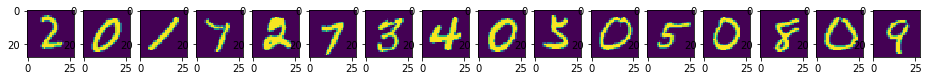

In [12]:
import random
import gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


images_file = "t10k-images-idx3-ubyte.gz"

def read_mnist(data_dir, images_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), 'rb') as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return images


X = read_mnist(local_data_dir, images_file)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images 
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])
    
# preprocess the data to be consumed by the model

def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std

samples = normalize(samples, axis=(1,2))
samples = np.expand_dims(samples, axis=3)


In [14]:
predictions = predictor.predict(samples)['predictions'] 

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)

print("Predictions: ", *predictions)

Predictions:  2 0 1 7 2 7 3 4 0 5 0 5 0 8 0 9


## (Optional) Clean Up
If you do not plan to use the endpoint, you should delete it to free up some computation resource.

In [ ]:
predictor.delete_endpoint()